## Week 7: The decision tree classfier; and two concepts: impurity(entropy) and information gain

Instructor: Cornelia Paulik <br>
Email: cilin@ischool.berkeley.edu <br>

---
#### ``Readings``


1. Raschka & Mirjalili (RM), 3rd edition: Chapter 3 (pp. 90-103) in the print version of the book.

#### ``Learning Objectives``
 - short intro on decission tree learning.
 - experiments with entropy, information gain, and decision trees.
 - 
- Define decision trees and their components (nodes, branches, leaves).
- Explain how decision trees make predictions through feature splits.
- Use entropy and information gain to construct decision trees on sample datasets.
- Compare different splitting criteria and their effects on tree depth and accuracy.

#### ``Decission tree learning``
 - used for classifying non-linearly separable data (can build complex decission bounderies by dividing the feature space into rectangles).
 - based on the features of the training set, the decission tree classifier learns a series of questions to infer the class labels.
 - can be used for both categorical and real numbered variables (if a real number, just define a cut-off value to ask a binary question).
 - we start at the tree root (contains all data) and split the data on the feature that results in the largest **Information Gain (IG)**.
 - using an iterative process, repeat the splitting procedure at each child node until you reach the leaf node (i.e., when the training examples at each node all belong to the same class).
 - be aware of overfitting issues! this can happen if the tree becomes too long! Make sure to **prune** the tree by setting a maximal depth of the tree.

---
### Step 1: Import packages

I am using the following package versions:
* Pandas: 2.2.2
* Numpy: 1.26.4
* Matplotlib: 3.8.4
* Seaborn: 0.13.2
* Sklearn: 1.4.2
* IPython: 8.25.0
* Mlxtend: 0.23.3
* Tensorflow: 2.17.0
* Statsmodels: 0.14.2
* Shap: 0.46.0
* pydot-3.0.4
* pydotplus-2.0.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For producing decision tree diagrams.
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from sklearn.datasets import load_iris

/var/folders/nv/6cnqsdb57bngjtdgbjtw7ky80000gr/T/ipykernel_8814/87762760.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


### Step 2: Define functions

In [4]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [5]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    unique_labels = np.unique(labels)  # Get unique labels
    label_probs = np.zeros(len(unique_labels))  # Create correct size array

    for label in labels:
        label_index = np.where(unique_labels == label)[0][0]  # Map label to index
        label_probs[label_index] += 1.0  # Increment count

    return label_probs / label_probs.sum()  # Normalize to get probabilities


In [6]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [7]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

---
### Step 3: Read data
---

In [8]:
df = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']

print('Shape of df wine:', df.shape)
print('Class labels:', df['class_label'].unique())
print()
df.head()

Shape of df wine: (178, 14)
Class labels: [1 2 3]



,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
### Step 4: Data preprocessing
---

#### Rename class labels

In [9]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping

df['class_label'] = df.class_label.map(class_mapping)
print('Class labels:', df.class_label.unique())

Class labels: [0 1 2]


#### Data subseting

We will be working with all class labels but only four features ['alcohol', 'malic_acid', 'ash', 'flavanoids'].

In [10]:
labels = ['class_label']
features = ['alcohol', 'malic_acid', 'ash', 'color_intensity']
df = df[labels+features]
df.head()

,class_label,alcohol,malic_acid,ash,color_intensity
0,0,14.23,1.71,2.43,5.64
1,0,13.20,1.78,2.14,4.38
2,0,13.16,2.36,2.67,5.68
3,0,14.37,1.95,2.50,7.80
4,0,13.24,2.59,2.87,4.32


#### Binarize feature values

To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "low"=0 or "high"=1. I'm just going to choose a threshold for each feature. Threshold = mean value of the feature.

In [11]:
binarize_threshold = []
df_b = df.copy()

for feature in features:
    df_b[feature] = np.where(df_b[feature] >= df_b[feature].mean(), 1, 0)
    binarize_threshold.append(df_b[feature].mean())
print('Binarize thresholds:\n', binarize_threshold)
df_b.head()

Binarize thresholds:
 [0.5168539325842697, 0.37640449438202245, 0.48314606741573035, 0.43820224719101125]


,class_label,alcohol,malic_acid,ash,color_intensity
0,0,1,0,1,1
1,0,1,0,0,0
2,0,1,1,1,1
3,0,1,0,1,1
4,0,1,1,1,0


#### Create training and test sets

In [12]:
# Create X and y arrays for the non-binarized and binarized versions
X = np.array(df.iloc[:, 1:])
y = np.array(df.iloc[:, 0])

X_b = np.array(df_b.iloc[:, 1:])
y_b = np.array(df_b.iloc[:, 0])

# First, split into training (60%) and temp (40%) [validation + test]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4,
                                                    random_state=1, stratify=y)

X_b_train, X_b_temp, y_b_train, y_b_temp = train_test_split(X_b, y_b, test_size=0.4,
                                                            random_state=1, stratify=y_b)

# Next, split temp into validation (50% of temp = 20% total) and test (50% of temp = 20% total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                random_state=1, stratify=y_temp)

X_b_val, X_b_test, y_b_val, y_b_test = train_test_split(X_b_temp, y_b_temp, test_size=0.5,
                                                        random_state=1, stratify=y_b_temp)

# Print dataset shapes
print(f'Shape X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}')
print(f'Shape y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')
print(f'Shape X_b_train: {X_b_train.shape}, X_b_val: {X_b_val.shape}, X_b_test: {X_b_test.shape}')
print(f'Shape y_b_train: {y_b_train.shape}, y_b_val: {y_b_val.shape}, y_b_test: {y_b_test.shape}')


Shape X_train: (106, 4), X_val: (36, 4), X_test: (36, 4)
Shape y_train: (106,), y_val: (36,), y_test: (36,)
Shape X_b_train: (106, 4), X_b_val: (36, 4), X_b_test: (36, 4)
Shape y_b_train: (106,), y_b_val: (36,), y_b_test: (36,)


Let's look at histograms of each features: non-binarized data.

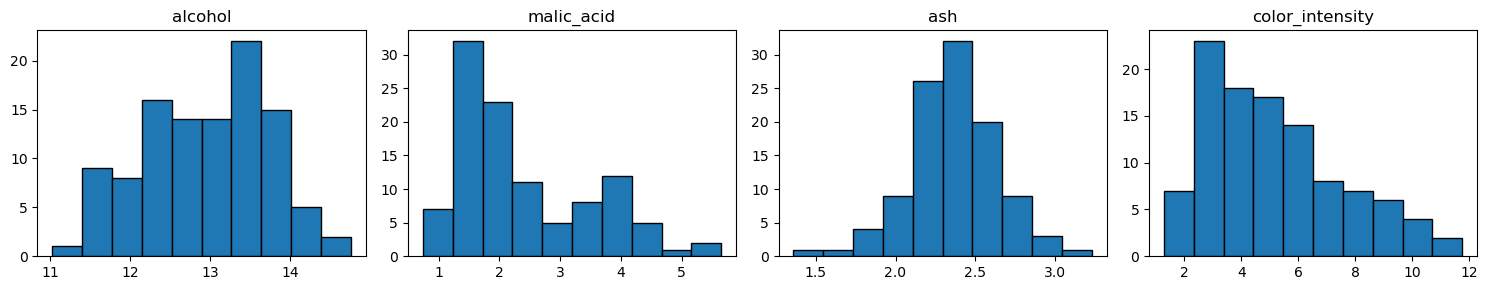

In [13]:
import matplotlib.pyplot as plt

# Create a single figure with 4 subplots in a 1x4 layout
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# Loop through each feature and corresponding subplot
for idx, feature in enumerate(features):
    axes[idx].hist(pd.DataFrame(X_train, columns=[features])[feature], bins=10, edgecolor='black')
    axes[idx].set_title(feature)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Let's look at histograms of each features: binarized data.

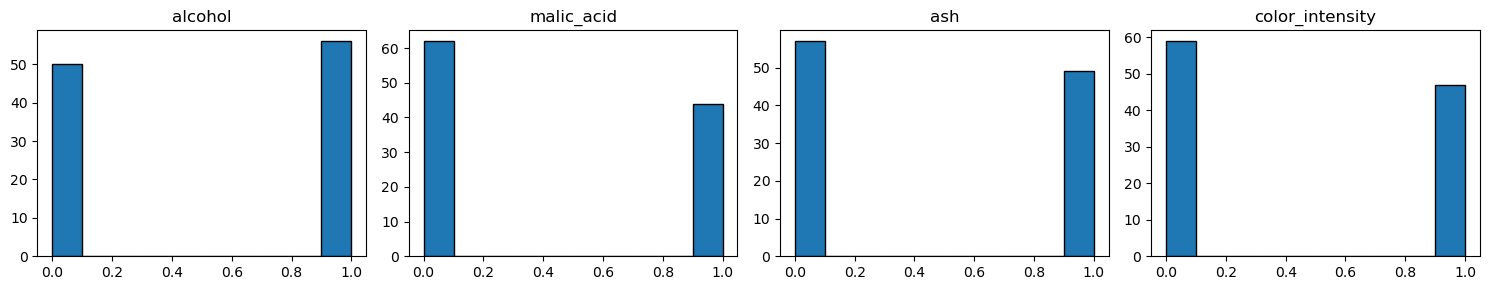

In [14]:
import matplotlib.pyplot as plt

# Create a single figure with 4 subplots in a 1x4 layout
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# Loop through each feature and corresponding subplot
for idx, feature in enumerate(features):
    axes[idx].hist(pd.DataFrame(X_b_train, columns=[features])[feature], bins=10, edgecolor='black')
    axes[idx].set_title(feature)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


---
### Step 5: Decission tree classifier
---

Based on the features in the wine dataset, the decission tree algo learns a series of questions to make predictions about class labels. 

The decission tree algo starts at the tree root (contains all data) and splits the data on the feature that results in the largest **Information Gain (IG)**.

Using an iterative process, the algo repeats the splitting procedure at each child node until a leaf node is reached (i.e., when the training examples at each node all belong to the same class).

---

#### Question: How do we decide what are the most informative features (a.k.a., child nodes)? 

---

**Objective**: maximize the **Information Gain (IG)** at each node split:

$IG(D_p,f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N_p} I(D_j)$,

where:
- $D_p$ = dataset of the parent node
- $D_j$ = dataset of the j_th child node
- $f$ = f is the feature to perform the split
- $I$ = our Impurity measure (we will use Entropy)
- $N_p$ = total number of training examples at the parent node
- $N_j$ = total number of training examples at the child j_th node

So the IG is the difference between the impurity of the parent node and the sum of the child node impurities (the lower the impurities of the child nodes, the larger the information gain).

For efficiency, most libraries (incl. scikit-learn) implement binary decission trees, meaning that each parent node is split into two child nodes: <br>
$IG(D_p,f) = I(D_p) - [\frac{N_j}{N_p} I(D_{left}) + \frac{N_j}{N_p} I(D_{right})]$,

We are missing only one thing, the definition of our impurity measure (**entropy**):

$I(t) = -\sum_{i=1}^{c} p(i|t) \times log_2 p(i|t)$

where:
- $p(i|t)$ is the proportion of examples that belong to class $i$ for a particular node, $t$

So the entropy is zero if all example at a node belong to the same class, and it's maximal if we have a uniform distribution (even split between class labels). In other words, entropy is a measure of uncertainty, and it is maximized when the distribution is uniform.

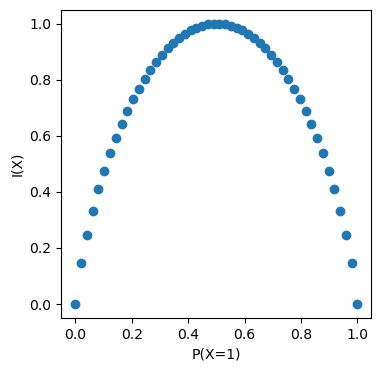

In [15]:
# Show a plot of the entropy, I(X), of a Bernoulli random variable X.
p_values = np.linspace(0, 1, 50)
entropies = [entropy([p, 1-p]) for p in p_values]  #Note: the entropy function is defined at the top
plt.figure(figsize=(4,4))
plt.plot(p_values, entropies, 'o')
plt.xlabel('P(X=1)');
plt.ylabel('I(X)');

#### Compute the impurity (entropy) of the parent dataset

In other words, we are interested in the entropy of our distribution over labels. You may recall that the distribution in the training data is nearly uniform.

In [16]:
label_probs = get_parent_distribution(y_b_train)
print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3, 1./3]))

Parent distribution [0.33018868 0.39622642 0.27358491]
Parent entropy: 1.5686403959926207
Uniform entropy: 1.584962500721156


#### Compute the impurity of the child nodes

In other words, we want to look at the entropy of each subset of the labels after splitting on each feature. 

Note: no code here because this step is included in the information_gain() function. I will leave it to you to split it in a separate function.

In [17]:
features

['alcohol', 'malic_acid', 'ash', 'color_intensity']

#### Compute the information gain (IG) for each feature

In [18]:
for feature in range(len(features)):
    IG = information_gain(X_b_train, y_b_train, feature)
    print ('%d %.3f %s' %(feature, IG, features[feature]))

0 0.459 alcohol
1 0.281 malic_acid
2 0.038 ash
3 0.379 color_intensity


According to the information gain metric, alcohol is the most useful feature, followed by color intensity and malic acid. Let's confirm that this agrees with the sklearn decision tree implementation. Actually, sklearn doesn't expose the information gain values. Instead, it stores the distribution of "feature importances", which reflects the value of each feature in the full decision tree. Let's train a decision tree with max_depth=1 so it will only choose a single feature. Let's also get the test accuracy with this "decision stump".

Using a decision stump -- a tree with depth 1:
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [1. 0. 0. 0.]
Accuracy on train data: 0.6698113207547169
Accuracy on validation data: 0.6944444444444444


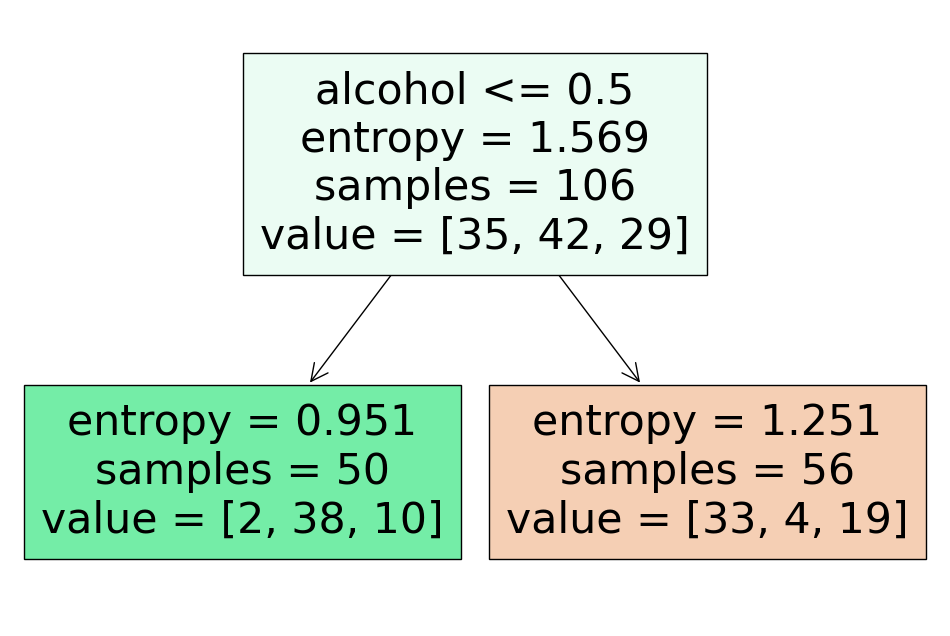

In [19]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = dt.fit(X_b_train, y_b_train)
# Increase figure size before plotting
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plot_tree(clf, feature_names=features, filled=True);  # Include feature names and colors
print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy on train data:', dt.score(X_b_train, y_b_train))
print ('Accuracy on validation data:', dt.score(X_b_val, y_b_val))

Question: Are any of the child nodes pure when we use only one feature (max_depth=1)?

---
We've been using the binarized version of the wine features. Recall that we simply chose thresholds for each feature by taking the mean of each feature. Let's use **information gain (IG)** as a metric to choose a best feature and a best threshold.

In [20]:
try_features_and_thresholds(X_train, y_train)

feature best_threshold best_IG feature name
0 12.792 0.564 alcohol
1 2.549 0.283 malic_acid
2 2.049 0.133 ash
3 3.484 0.570 color_intensity


Let's try training a stump decision tree with the original (non-binarized) data. 

Accuracy on train data: 0.6792452830188679
Accuracy on validation data: 0.6944444444444444
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [1. 0. 0. 0.]


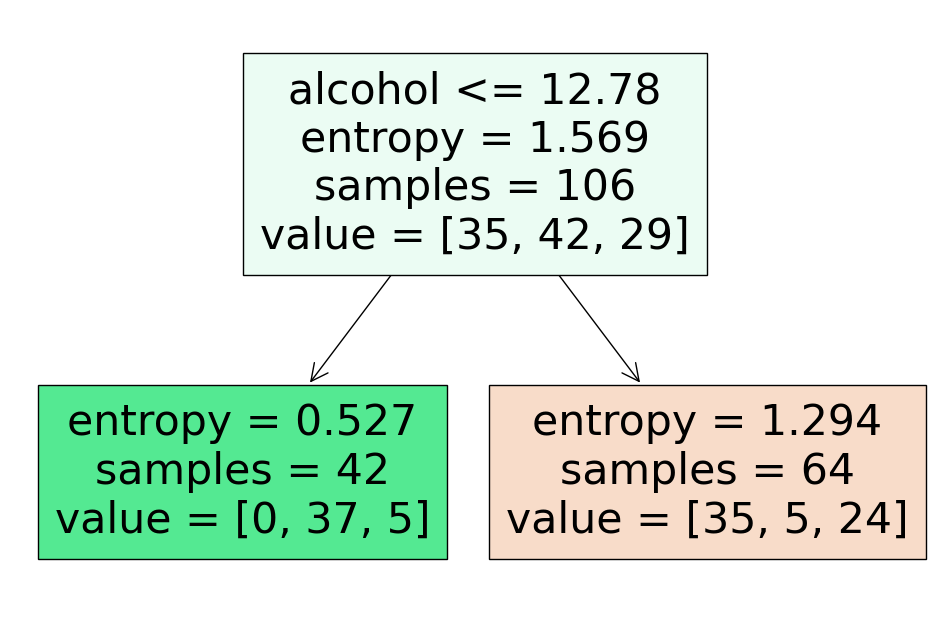

In [21]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = dt.fit(X_train, y_train)
print('Accuracy on train data:', dt.score(X_train, y_train))
print('Accuracy on validation data:', dt.score(X_val, y_val))

# Increase figure size before plotting
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plot_tree(clf, feature_names=features, filled=True);  # Include feature names and colors

# Print feature importance
print('Features:', features)
print('Feature importances:', dt.feature_importances_)


Now let's try training a decision tree (depth=3) with the original (non-binarized) data. 

Accuracy on training data: 0.8962264150943396
Accuracy on validation data: 0.8055555555555556
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [0.47000161 0.29714463 0.         0.23285376]


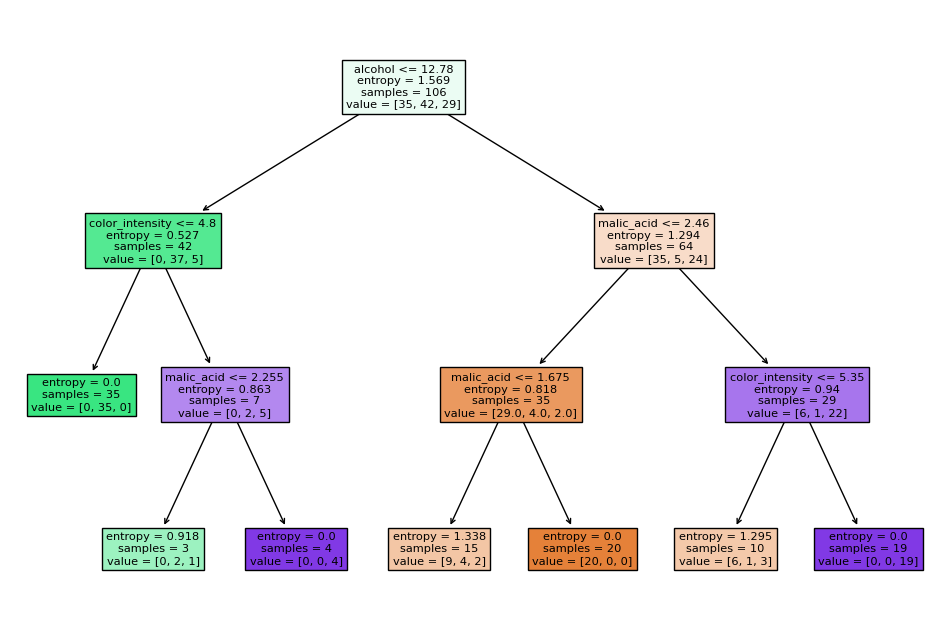

In [22]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = dt.fit(X_train, y_train)
print('Accuracy on training data:', dt.score(X_train, y_train))
print('Accuracy on validation data:', dt.score(X_val, y_val))

# Increase figure size before plotting
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plot_tree(clf, feature_names=features, filled=True);  # Include feature names and colors

# Print feature importance
print('Features:', features)
print('Feature importances:', dt.feature_importances_)


---
### Step 6: Random Forest Classifier (Ensemble methods)
---

Let's now train a random forest classifier, which is actually just an ensamble of decision trees. The idea is to average multiple (deep) decision trees to improve generalization performance. The algorithm is less susceptible to overfitting.

In [23]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=40, 
                                random_state=1,
                                n_jobs=2)
clf_forest = forest.fit(X_train, y_train)

print ('Accuracy on training data:', clf_forest.score(X_train, y_train))
print ('Accuracy on validation data:', clf_forest.score(X_val, y_val))

print('Features:', features)
print ('Feature importances:', clf_forest.feature_importances_)
#tree.export_graphviz(clf)

Accuracy on training data: 1.0
Accuracy on validation data: 0.8611111111111112
Features: ['alcohol', 'malic_acid', 'ash', 'color_intensity']
Feature importances: [0.34181638 0.18829384 0.0784964  0.39139337]
